# Analysis of the SisFall Dataset for Fall Detection
## Matthew Johnson

[ROUGH WORK]

| Subject | Age | Height | Weight | Gender |      |     | Subject | Age | Height | Weight | Gender |
---------|-----|--------|--------|-------- |  --- |  ---|---------|-----|--------|--------|--------         
| SA01    | 26  | 165    | 53     | F      |      |     | SA13    | 22  | 157    | 55     | F      |
| SA02    | 23  | 176    | 58.5   | M      |      |     | SA14    | 27  | 160    | 46     | F      |
| SA03    | 19  | 156    | 48     | F      |      | | SA15    | 25  | 160    | 52     | F      |
| SA04    | 23  | 170    | 72     | M      |      | | SA16    | 20  | 169    | 61     | F      |
| SA05    | 22  | 172    | 69.5   | M      |      | | SA17    | 23  | 182    | 75     | M      |
| SA06    | 21  | 169    | 58     | M      |      | | SA18    | 23  | 181    | 73     | M      |
| SA07    | 21  | 156    | 63     | F      |      | | SA19    | 30  | 170    | 76     | M      |
| SA08    | 21  | 149    | 41.5   | F      |      | | SA20    | 30  | 150    | 42     | F      |
| SA09    | 24  | 165    | 64     | M      |      | | SA21    | 30  | 183    | 68     | M      |
| SA10    | 21  | 177    | 67     | M      |      | | SA22    | 19  | 158    | 50.5   | F      |
| SA11    | 19  | 170    | 80.5   | M      |      | | SA23    | 24  | 156    | 48     | F      |
| SA12    | 25  | 153    | 47     | F      |      |

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
import time
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt

df1 = pd.read_csv('aug24_sisfall.csv')
df2 = pd.read_csv('aug24_sisfall_std.csv')

In [98]:
pivot1 = pd.pivot_table(index=['activity', 'subject'], 
                       values=['horiz_vector_mag', 'vector_mag', 'diff_vector_mag'],
                       aggfunc=max, data=df1)

pivot_wtrial = pd.pivot_table(index=['activity', 'subject', 'trial'], 
                       values=['horiz_vector_mag', 'vector_mag', 'diff_vector_mag'],
                       aggfunc=max, data=df1)

pivot2 = pd.pivot_table(index=['activity', 'subject'], values=['vector_mag_rolling_std', 
            'horiz_vector_mag_rolling_std'], aggfunc=max, data=df2)

pivot2_wtrial = pd.pivot_table(index=['activity', 'subject', 'trial'], values=['vector_mag_rolling_std', 
            'horiz_vector_mag_rolling_std'], aggfunc=max, data=df2)

In [55]:
# D01 walking slowly, D02 walking quickly, D03 jogging slowly, D04 jogging quickly

In [29]:
subj_info = pd.read_csv('/Users/mattjohnson/PycharmProjects/SisFallAnalysis/subject_info.csv')

In [42]:
subj_info.columns = subj_info.columns.str.strip()
subj_info['Subject'] = subj_info['Subject'].str.strip()
subj_info['Gender'] = subj_info['Gender'].str.strip()

wt_dict = subj_info.set_index('Subject')['Weight'].to_dict()
gen_dict = subj_info.set_index('Subject')['Gender'].to_dict()
ht_dict = subj_info.set_index('Subject')['Height'].to_dict()
age_dict = subj_info.set_index('Subject')['Age'].to_dict()

In [100]:
def add_feats(pivot):
    pivot['index'] = pivot.index
    pivot['FallActivity'] = pivot['index'].apply(lambda x: x[0][0])
    pivot['activity'] = pivot['index'].apply(lambda x: x[0])
    pivot['Subject'] = pivot['index'].apply(lambda x: x[1])
    pivot['Weight'] = pivot['Subject'].map(wt_dict)
    pivot['Height'] = pivot['Subject'].map(ht_dict)
    pivot['Age'] = pivot['Subject'].map(age_dict)
    pivot['Gender'] = pivot['Subject'].map(gen_dict)
    
    return pivot

In [101]:
pivot_wtrial = add_feats(pivot_wtrial)
dataframe = pd.concat([pivot_wtrial, pivot2_wtrial], axis=1)
dataframe['Male'] = np.where(dataframe['Gender']=='M', 1, 0)
df = dataframe[['diff_vector_mag', 'horiz_vector_mag', 'vector_mag', 'FallActivity', 'Weight', 'Height', 'Age', 'Male', 
           'horiz_vector_mag_rolling_std', 'vector_mag_rolling_std']]
df.reset_index(drop=True, inplace=True)

Below: Amplitudes inversely proportional?

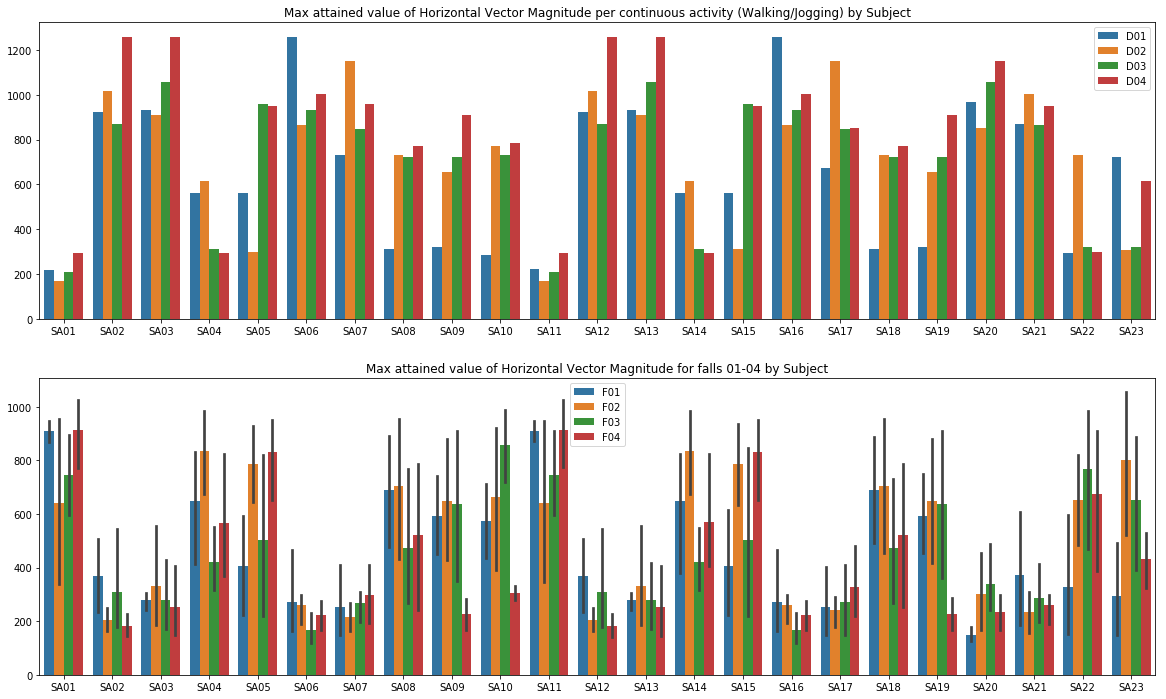

In [204]:
baselines = dataframe.loc['D01':'D04']
plt.subplots(figsize=(20,12))
plt.subplot(2, 1, 1)
sns.barplot(x=baselines['Subject'].values, y=baselines['horiz_vector_mag'].values, hue=baselines['activity'].values)
plt.title('Max attained value of Horizontal Vector Magnitude per continuous activity (Walking/Jogging) by Subject');

plt.subplot(2, 1, 2)
falls_1 = dataframe.loc['F01':'F04']
sns.barplot(x=falls_1['Subject'].values, y=falls_1['horiz_vector_mag'].values, hue=falls_1['activity'].values)
plt.title('Max attained value of Horizontal Vector Magnitude for falls 01-04 by Subject');

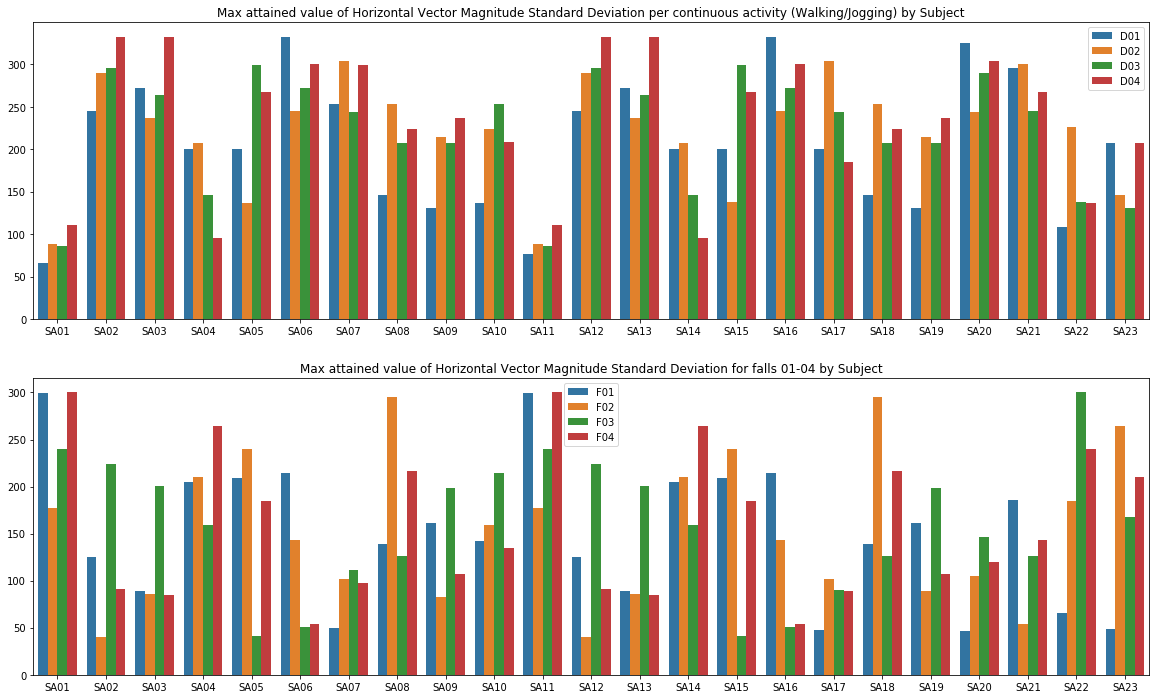

In [206]:
baselines = dataframe.loc['D01':'D04']
plt.subplots(figsize=(20,12))
plt.subplot(2, 1, 1)
sns.barplot(x=baselines['Subject'].values, y=baselines['horiz_vector_mag_rolling_std'].values, hue=baselines['activity'].values)
plt.title('Max attained value of Horizontal Vector Magnitude Standard Deviation per continuous activity (Walking/Jogging) by Subject');

plt.subplot(2, 1, 2)
falls_1 = dataframe.loc['F01':'F04']
sns.barplot(x=falls_1['Subject'].values, y=falls_1['horiz_vector_mag_rolling_std'].values, hue=falls_1['activity'].values)
plt.title('Max attained value of Horizontal Vector Magnitude Standard Deviation for falls 01-04 by Subject');

In [268]:
subjects = []
for i in range(1,24):
    subjects.append('SA'+str(i).zfill(2))
    
horiz_vm_std_means = []
horiz_vm_std_meansF = []
for sub in subjects:
    horiz_vm_std_sum = 0
    for activity in ['D01', 'D02', 'D03', 'D04']:
        horiz_vm_std_sum += dataframe.loc[activity,sub]['horiz_vector_mag_rolling_std'].values[0]
    horiz_vm_std_means.append(horiz_vm_std_sum/4.0)

    horiz_vm_std_sum = 0
    for activity in ['F01', 'F02', 'F03', 'F04']:
        horiz_vm_std_sum += dataframe.loc[activity,sub]['horiz_vector_mag_rolling_std'].values[0]
    horiz_vm_std_meansF.append(horiz_vm_std_sum/4.0)

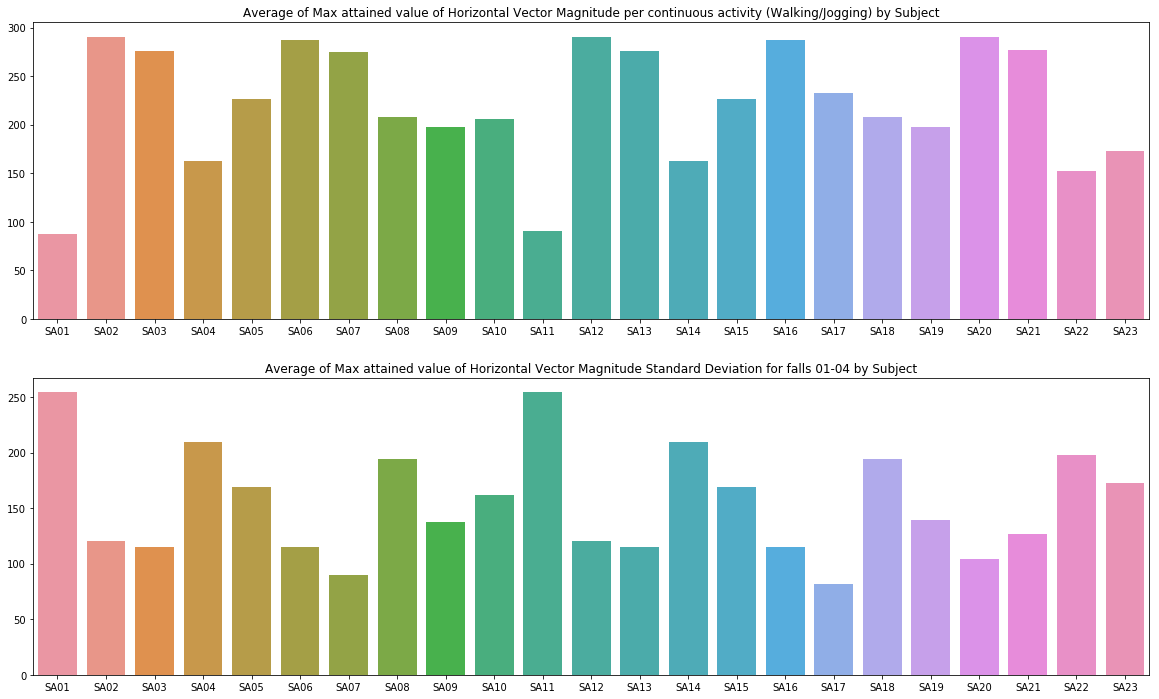

In [281]:
plt.subplots(figsize=(20,12))
plt.subplot(2, 1, 1)
sns.barplot(x=subjects, y=horiz_vm_std_means);
plt.title('Average of Max attained value of Horizontal Vector Magnitude per continuous activity (Walking/Jogging) by Subject');

plt.subplot(2, 1, 2)
sns.barplot(x=subjects, y=horiz_vm_std_meansF);
plt.title('Average of Max attained value of Horizontal Vector Magnitude Standard Deviation for falls 01-04 by Subject');

In [276]:
corr_df = pd.DataFrame({'ADLs':horiz_vm_std_means, 'Falls':horiz_vm_std_meansF})
corr_df['diff']=corr_df['ADLs']-corr_df['Falls']
corr_df.index = subjects

corr_df['ADLs'].corr(corr_df['Falls'])

-0.8923494315579662

In [292]:
def add_subject_feats(pivot):
    pivot['Subject'] = pivot.index
    pivot['Weight'] = pivot['Subject'].map(wt_dict)
    pivot['Height'] = pivot['Subject'].map(ht_dict)
    pivot['Age'] = pivot['Subject'].map(age_dict)
    pivot['Gender'] = pivot['Subject'].map(gen_dict)
    
    return pivot

In [293]:
corr_df = add_subject_feats(corr_df)

In [301]:
corr_df['male'] = np.where(corr_df['Gender']=='M', 1, -1)

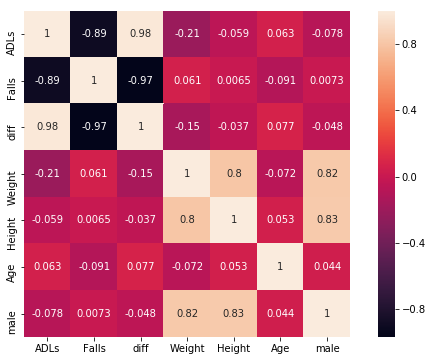

In [302]:
plt.subplots(figsize=(10,6))
sns.heatmap(corr_df.corr(), annot=True, square=True)

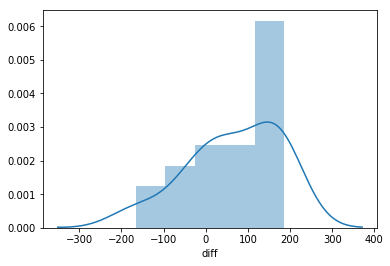

In [287]:
sns.distplot(corr_df['diff'], bins=5)

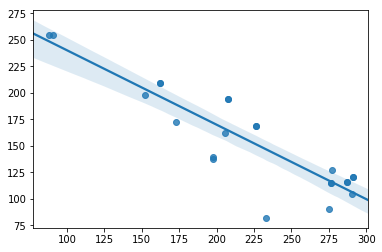

In [278]:
sns.regplot(x=horiz_vm_std_means, y=horiz_vm_std_meansF)

In [141]:
ytest.sum()/len(ytest)

0.49743589743589745

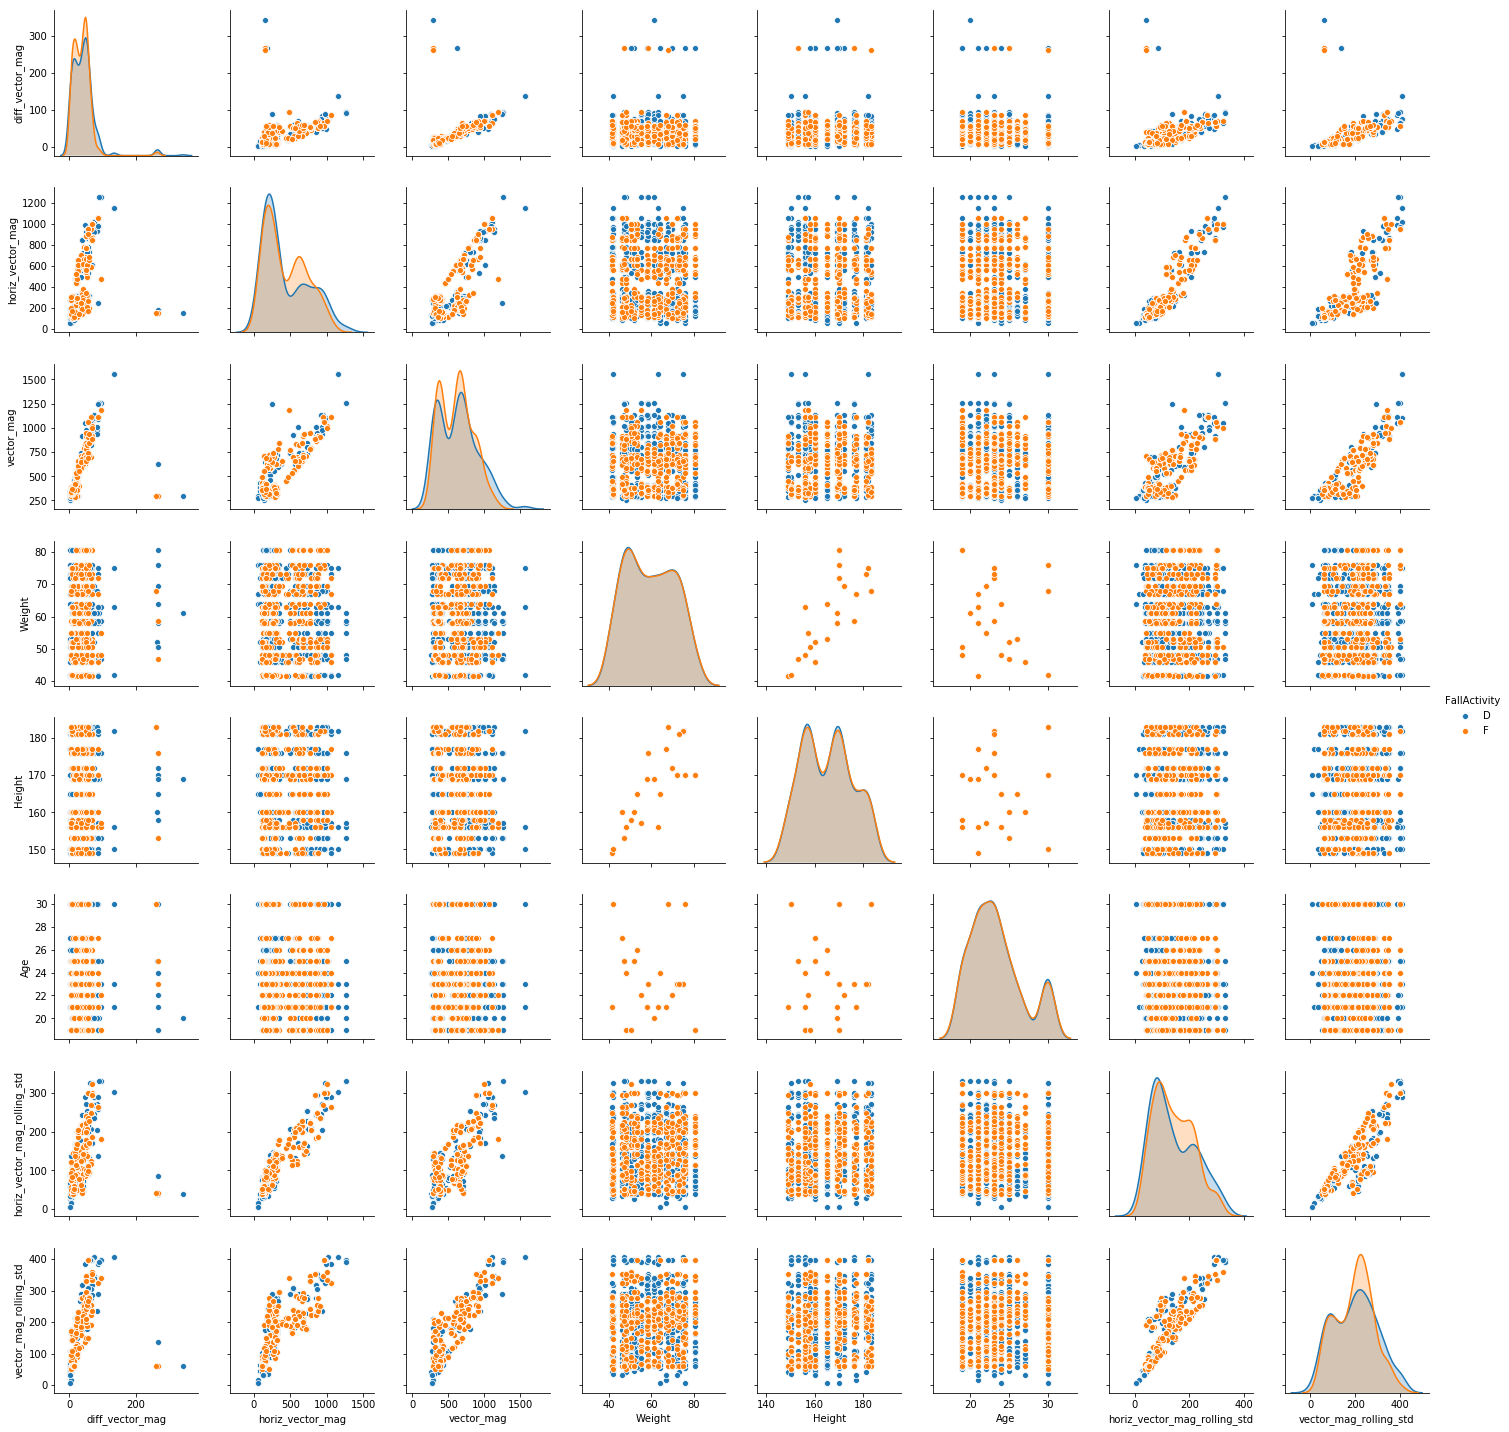

In [163]:
#df6['activity'] = df6['activity'].astype('category')
sns.pairplot(df.drop(['Male'], axis=1), hue='FallActivity');